In [ ]:
import pandas as pd
import numpy as np
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from scipy.spatial.distance import cosine 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.stats.mstats import gmean
import scanpy as sc
import squidpy as sq
import pickle
import os
import torch
import seaborn as sns
from transpa.util import expTransImp
from plotting import score_MI, score_sparkX, score_SDM
import warnings
# importlib.reload(score_MI);importlib.reload(score_sparkX);reload(score_SDM)


warnings.filterwarnings('ignore')
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pre_path_root = "../../output/preprocessed_dataset/"
ST_names = ["mouseliver5fold", "melanoma5fold", "intestine5fold", "breastcancer5fold"]
pre_datasets = ["mouseliver.pkl",   "melanoma.pkl", "intestine.pkl", "breastcancer.pkl"]
methods = ["TransImpSpa", "TransImpClsSpa", "TransImpLR", "TransImpCls", "spaGE", "stPlus", "Tangram", "truth"]
color = ['#845B53', '#D684BD', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2']

In [2]:
def prepare_data(ST_name, pre_datapath, genes=None):
    eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
    
    with open(eval_res_path, 'rb') as infile:
        eval_res, spa_adata, dict_adata = pickle.load(infile)
    _genes = genes
    if not _genes is None: 
        _genes = np.intersect1d(dict_adata['truth'].var_names, genes)
    df_I_auprc = score_MI(dict_adata, methods, "prec_rec", ST_name[:-5], genes=_genes)
    df_I_auroc = score_MI(dict_adata, methods, "roc", ST_name[:-5], genes=_genes)
    
    ######
    dict_sparkx_adjpvals = {}
    ca_genes = None

    for md in methods:
        print(md)
        df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
        if ca_genes is None:
            ca_genes = df.index.values

        shared_gene = np.intersect1d(ca_genes, df.index.values)
        if len(shared_gene) < len(ca_genes):
            miss_gene  = np.setdiff1d(ca_genes, shared_gene)
            df = pd.concat([df, pd.DataFrame({"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
        dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
    
    _genes = genes
    if not _genes is None: 
        _genes = np.intersect1d(ca_genes, genes)
        
    df_sparkx_auprc = score_sparkX(
                              dict_sparkx_adjpvals, 
                              methods, 'prec_rec', ST_name[:-5], 
                              genes=_genes,
                              thred=0.01)
    df_sparkx_auroc = score_sparkX(dict_sparkx_adjpvals, 
                              methods, 'roc', ST_name[:-5], genes=_genes,
                              thred=0.01)
    #######
    with open(f"../../output/{ST_name}_spatialdm.pkl", 'rb') as infile:
        m_adatas = pickle.load(infile)
        
    _genes = genes
    if not _genes is None: 
        _genes = np.intersect1d(m_adatas['truth'].var_names, genes)
    df_sdm_auprc = score_SDM(m_adatas, 
                              methods,
                              "prec_rec",
                              ST_name[:-5],
                              genes=genes,
                              thred=0.01)
    df_sdm_auroc = score_SDM(m_adatas, 
                              methods,
                              "roc",
                              ST_name[:-5],
                              genes=genes,
                              thred=0.01)
    return df_I_auprc, df_I_auroc, df_sparkx_auprc, df_sparkx_auroc, df_sdm_auprc, df_sdm_auroc
    

In [3]:
df_scores = pd.DataFrame()
for pre_path, ST_name in zip(pre_datasets, ST_names):
    pre_datapath = os.path.join(pre_path_root, pre_path) 
    df_score_ = pd.concat(prepare_data(ST_name, pre_datapath, genes=None), axis=0)
    df_scores = pd.concat([df_scores, df_score_], axis=0)
        

TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth


In [4]:
df_scores

,method,score,stats,metric,dataset
0,TransImpSpa,0.384563,MoranI,prec_rec,mouseliver
1,TransImpClsSpa,0.396715,MoranI,prec_rec,mouseliver
2,TransImpLR,0.292857,MoranI,prec_rec,mouseliver
3,TransImpCls,0.203655,MoranI,prec_rec,mouseliver
4,spaGE,0.214833,MoranI,prec_rec,mouseliver
...,...,...,...,...,...
3,TransImpCls,0.658375,SDM,roc,breastcancer
4,spaGE,0.724531,SDM,roc,breastcancer
5,stPlus,0.584105,SDM,roc,breastcancer
6,Tangram,0.710672,SDM,roc,breastcancer


In [5]:
df_scores.query('method != "truth"')

,method,score,stats,metric,dataset
0,TransImpSpa,0.384563,MoranI,prec_rec,mouseliver
1,TransImpClsSpa,0.396715,MoranI,prec_rec,mouseliver
2,TransImpLR,0.292857,MoranI,prec_rec,mouseliver
3,TransImpCls,0.203655,MoranI,prec_rec,mouseliver
4,spaGE,0.214833,MoranI,prec_rec,mouseliver
...,...,...,...,...,...
2,TransImpLR,0.679250,SDM,roc,breastcancer
3,TransImpCls,0.658375,SDM,roc,breastcancer
4,spaGE,0.724531,SDM,roc,breastcancer
5,stPlus,0.584105,SDM,roc,breastcancer


[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

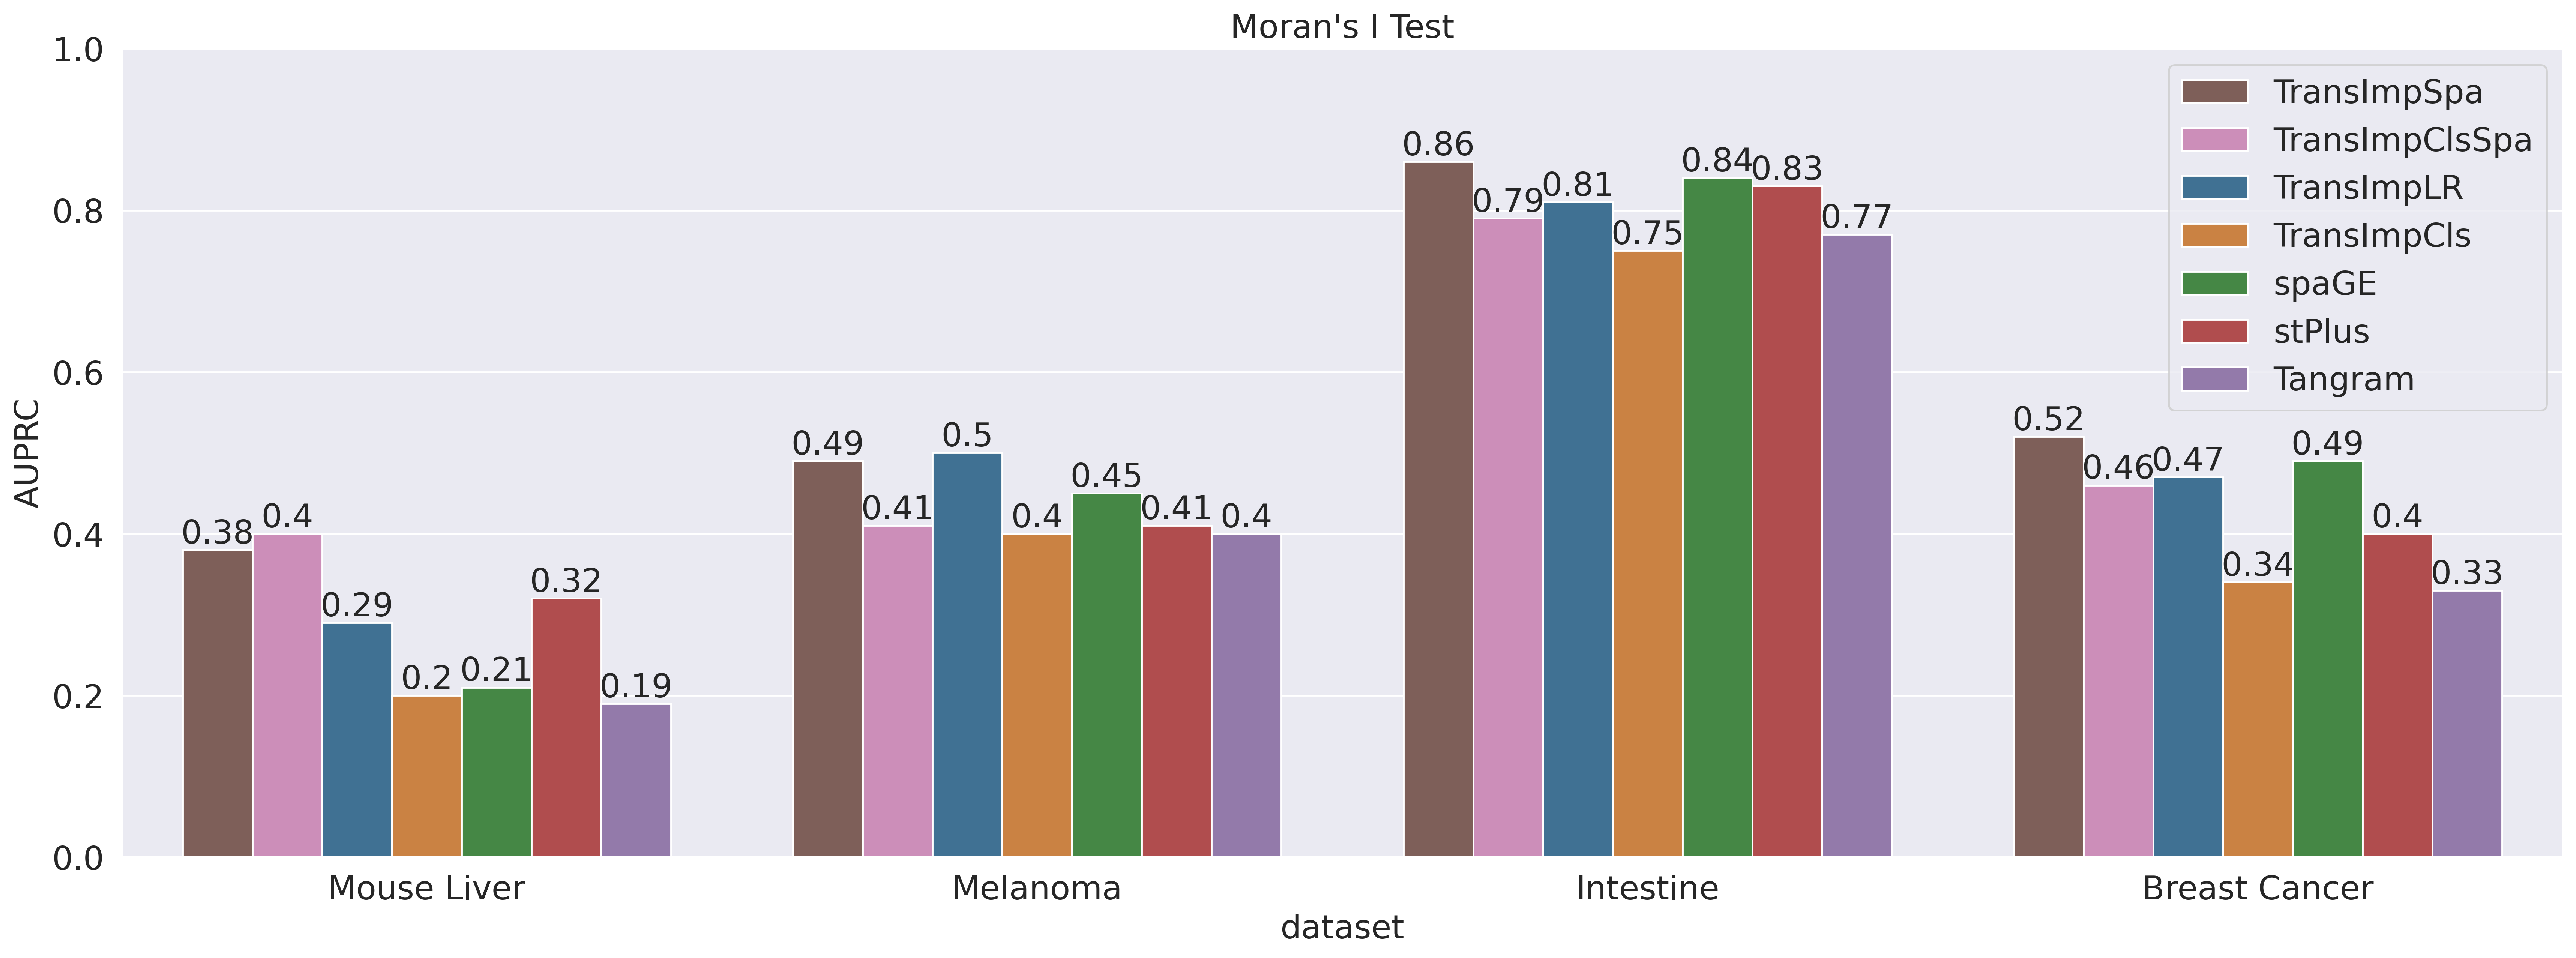

In [33]:
datasets = ["Mouse Liver", "Melanoma", "Intestine", "Breast Cancer"]
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
# data_order = [""]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores.query('metric == "prec_rec"')
                                 .query('stats=="MoranI"').query('method != "truth"').round(2), palette=color)
ax.set(
     title='Moran\'s I Test', ylim=(0, 1.0))

for i in ax.containers:
    ax.bar_label(i, )
    
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)


[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

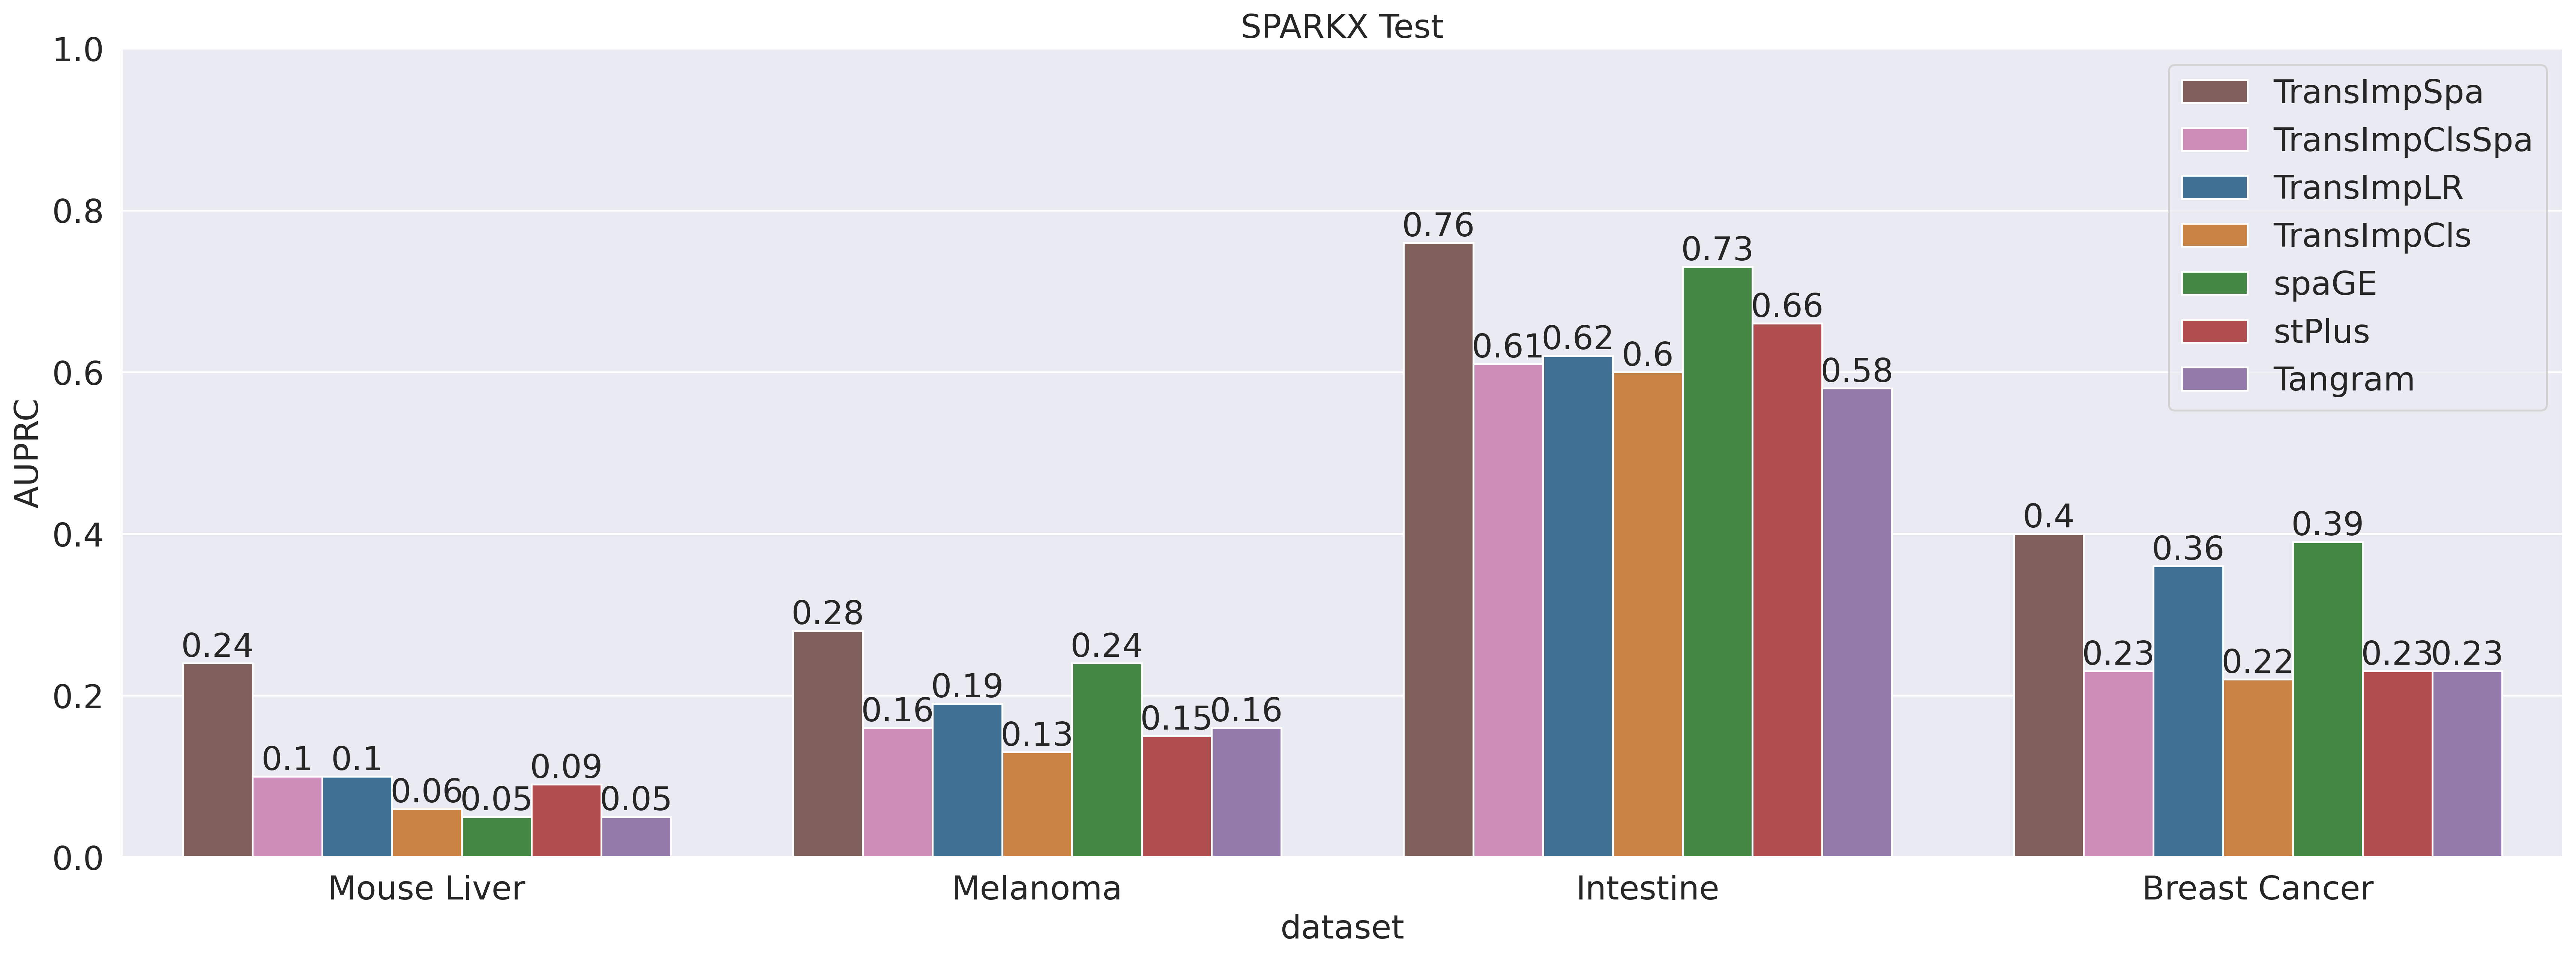

In [34]:
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
# data_order = [""]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores.query('metric == "prec_rec"')
                                 .query('stats=="SPARKX"').query('method != "truth"').round(2), palette=color)
ax.set(
    ylabel='AUPRC', title='SPARKX Test', ylim=(0, 1.0))

for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)

[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

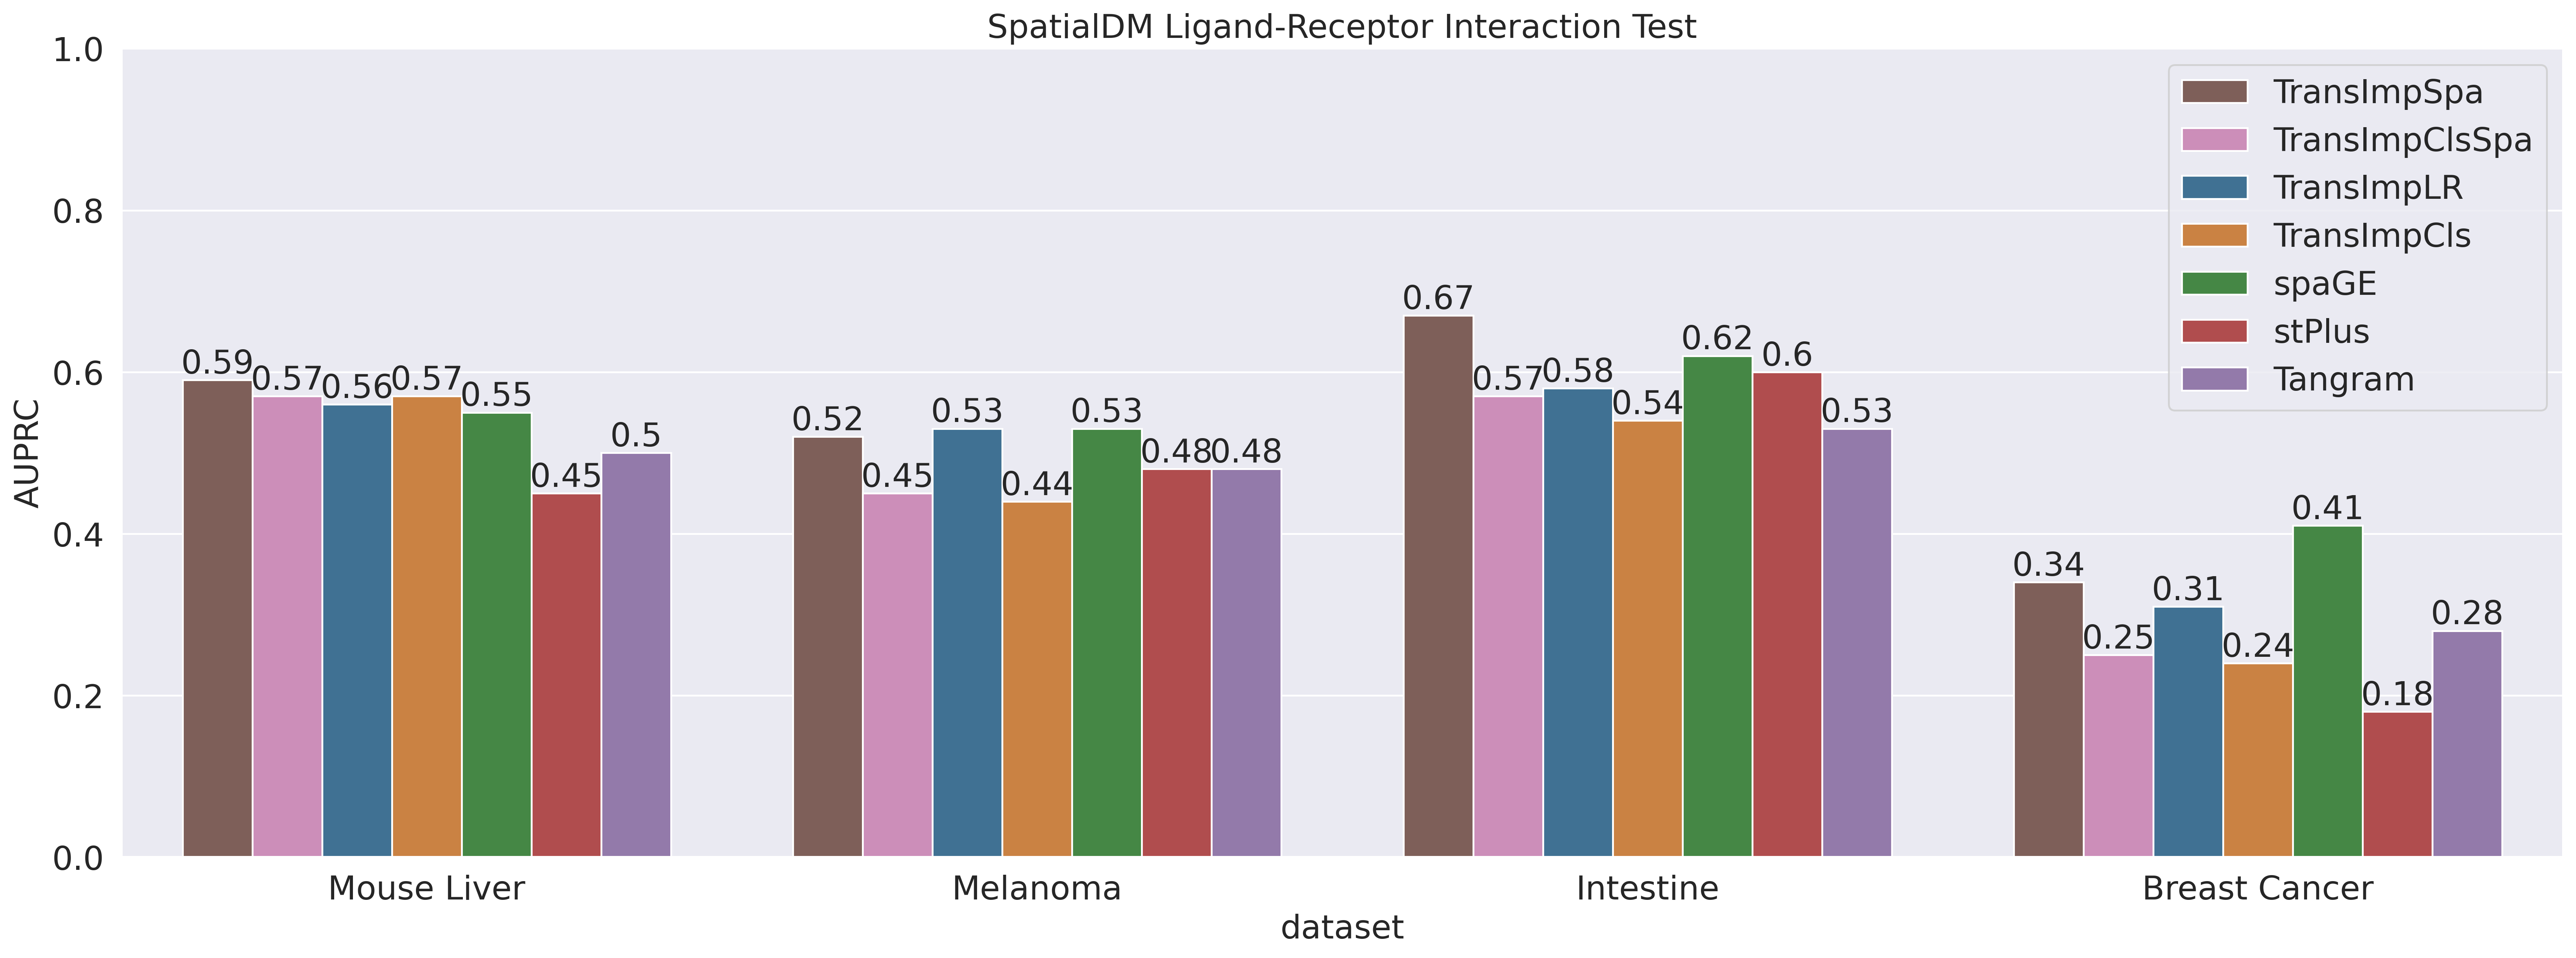

In [35]:
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
# data_order = [""]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores.query('metric == "prec_rec"')
                                 .query('stats=="SDM"').query('method != "truth"').round(2), palette=color)
ax.set(
    ylabel='AUPRC', ylim=(0, 1.0), title="SpatialDM Ligand-Receptor Interaction Test")
for i in ax.containers:
    ax.bar_label(i,)
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)

In [9]:
def get_pred_perf_variability(pre_datapath):    
    with open(pre_datapath, 'rb') as infile:
        spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
    cls_key = 'leiden'
    classes = scrna_adata.obs[cls_key]
    ct_list = np.unique(classes)  
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    kf.get_n_splits(raw_shared_gene)

    pred_perf_uncertainty = []
    test_gene_set = []
    
    for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):   
        train_gene = raw_shared_gene[train_ind]
        test_gene  = raw_shared_gene[test_ind]

        test_spatial_df = raw_spatial_df[test_gene]
        spatial_df = raw_spatial_df[train_gene]
        scrna_df   = raw_scrna_df

        transImpRes = expTransImp(
                        df_ref=raw_scrna_df,
                        df_tgt=raw_spatial_df,
                        train_gene=train_gene,
                        test_gene=test_gene,
                        n_simulation=200,
                        signature_mode='cell',
                        mapping_mode='lowrank',
                        classes=classes,
                        n_epochs=2000,
                        seed=seed,
                        device=device
        )
        pred_perf_uncertainty.extend(transImpRes[1])
        test_gene_set.extend(test_gene)
    df_gene_var = pd.DataFrame(index=test_gene_set)
    df_gene_var['gene'] = test_gene_set
    df_gene_var['perf_var'] = pred_perf_uncertainty
    
    return df_gene_var

In [10]:
df_pred_per_var = {}
for pre_path, ST_name in zip(pre_datasets, ST_names):
    pre_datapath = os.path.join(pre_path_root, pre_path) 
    df_pred_per_var[ST_name[:-5]] = get_pred_perf_variability(pre_datapath)

[TransImp] Epoch: 2000/2000, loss: 0.635374, (IMP) 0.635374: 100%|██████████| 2000/2000 [00:20<00:00, 97.93it/s] 
[TransImp] Epoch: 2000/2000, loss: 0.621230, (IMP) 0.621230: 100%|██████████| 2000/2000 [00:13<00:00, 151.89it/s]
[TransImp] Epoch: 2000/2000, loss: 0.632965, (IMP) 0.632965: 100%|██████████| 2000/2000 [00:12<00:00, 154.91it/s]
[TransImp] Epoch: 2000/2000, loss: 0.633332, (IMP) 0.633332: 100%|██████████| 2000/2000 [00:13<00:00, 153.00it/s]
[TransImp] Epoch: 2000/2000, loss: 0.621270, (IMP) 0.621270: 100%|██████████| 2000/2000 [00:13<00:00, 153.73it/s]
[TransImp] Epoch: 2000/2000, loss: 0.842746, (IMP) 0.842746: 100%|██████████| 2000/2000 [00:07<00:00, 256.14it/s]
[TransImp] Epoch: 2000/2000, loss: 0.853555, (IMP) 0.853555: 100%|██████████| 2000/2000 [00:08<00:00, 240.98it/s]
[TransImp] Epoch: 2000/2000, loss: 0.835014, (IMP) 0.835014: 100%|██████████| 2000/2000 [00:08<00:00, 239.58it/s]
[TransImp] Epoch: 2000/2000, loss: 0.853175, (IMP) 0.853175: 100%|██████████| 2000/2000 

In [11]:
df_scores_sub = pd.DataFrame()
for pre_path, ST_name in zip(pre_datasets, ST_names):
    pre_datapath = os.path.join(pre_path_root, pre_path) 
    genes = df_pred_per_var[ST_name[:-5]].query(f'perf_var < {np.quantile(df_pred_per_var[ST_name[:-5]].perf_var, 0.5)}').gene.values
    df_score_ = pd.concat(prepare_data(ST_name, pre_datapath, genes=genes), axis=0)
    df_scores_sub = pd.concat([df_scores_sub, df_score_], axis=0)
        

TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth
TransImpSpa
TransImpClsSpa
TransImpLR
TransImpCls
spaGE
stPlus
Tangram
truth


[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

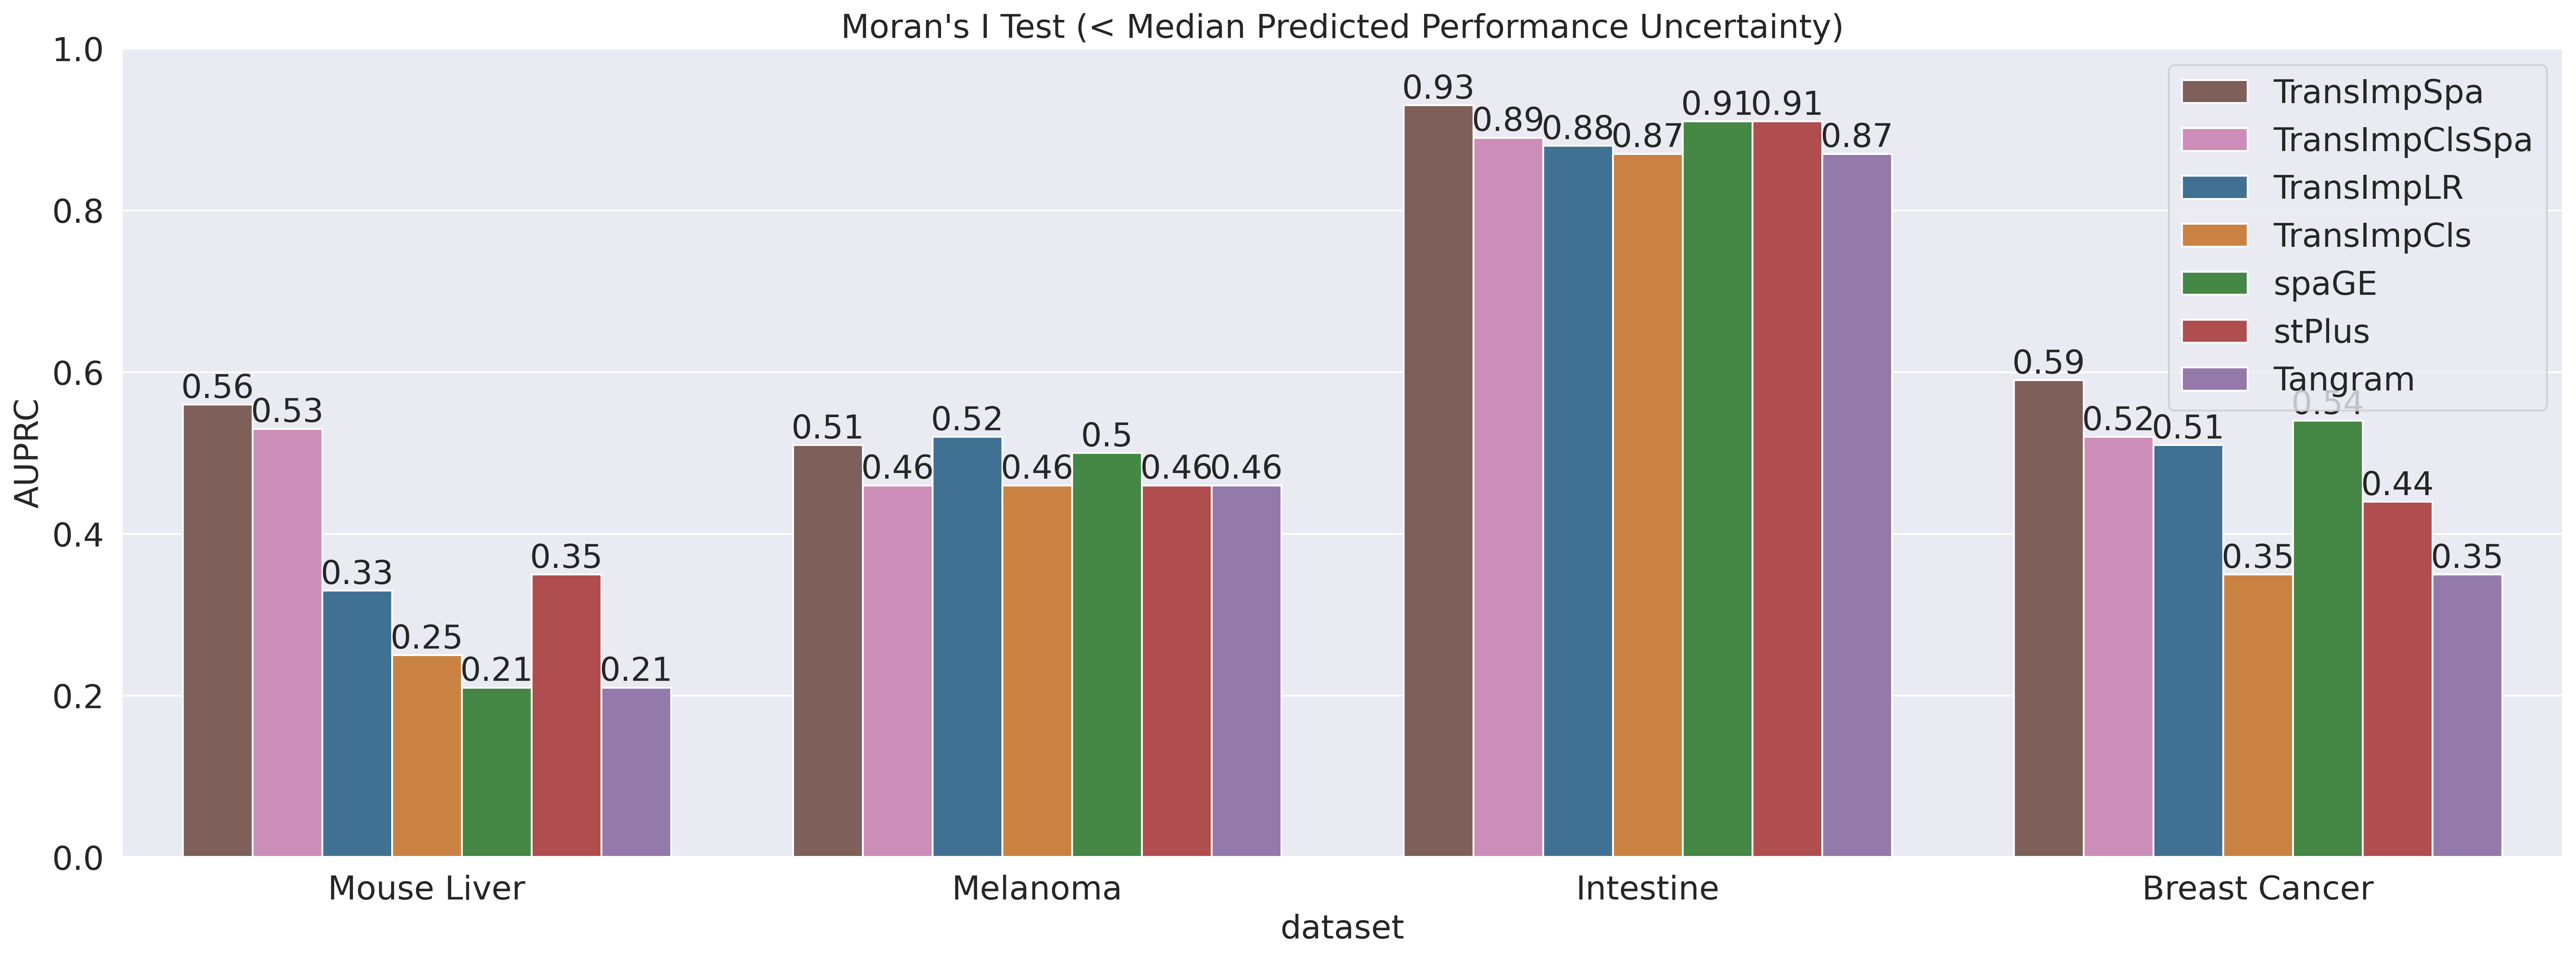

In [36]:
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
# data_order = [""]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores_sub.query('metric == "prec_rec"')
                                 .query('stats=="MoranI"').query('method != "truth"').round(2), palette=color)
ax.set(
    ylabel='AUPRC', title="Moran's I Test (< Median Predicted Performance Uncertainty)", ylim=(0, 1.0))
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)

[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

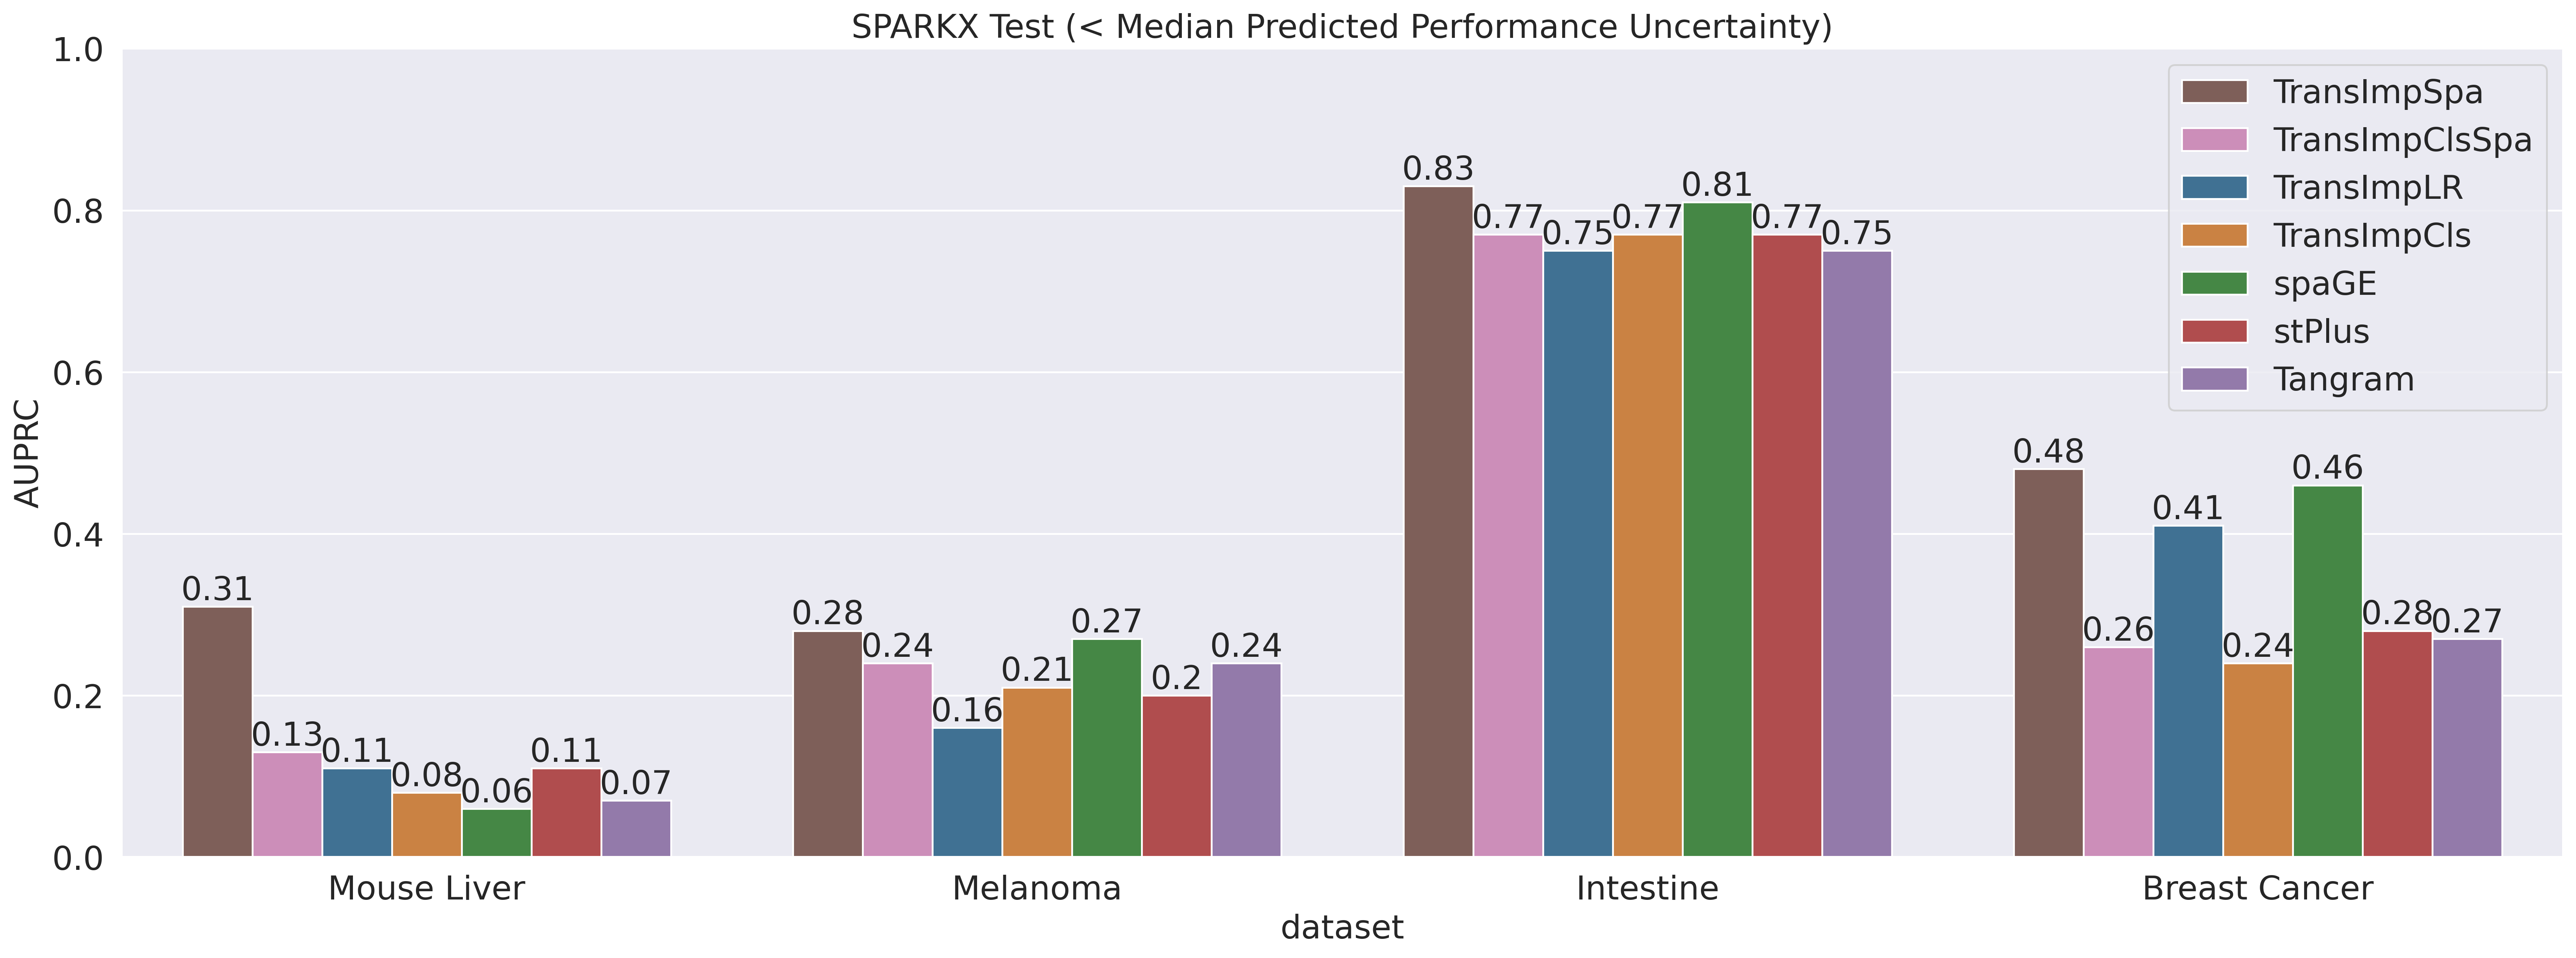

In [37]:
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
# data_order = [""]
# method_order = ['spaGE', 'stPlus', 'Tangram', "transImpCls", "transImpClsSpa", "transImpute", "transImpSpa"]
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores_sub.query('metric == "prec_rec"')
                                 .query('stats=="SPARKX"').query('method != "truth"').round(2), palette=color)
ax.set(
    ylabel='AUPRC', title= 'SPARKX Test (< Median Predicted Performance Uncertainty)', ylim=(0, 1.0))
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)

[Text(0, 0, 'Mouse Liver'),
 Text(1, 0, 'Melanoma'),
 Text(2, 0, 'Intestine'),
 Text(3, 0, 'Breast Cancer')]

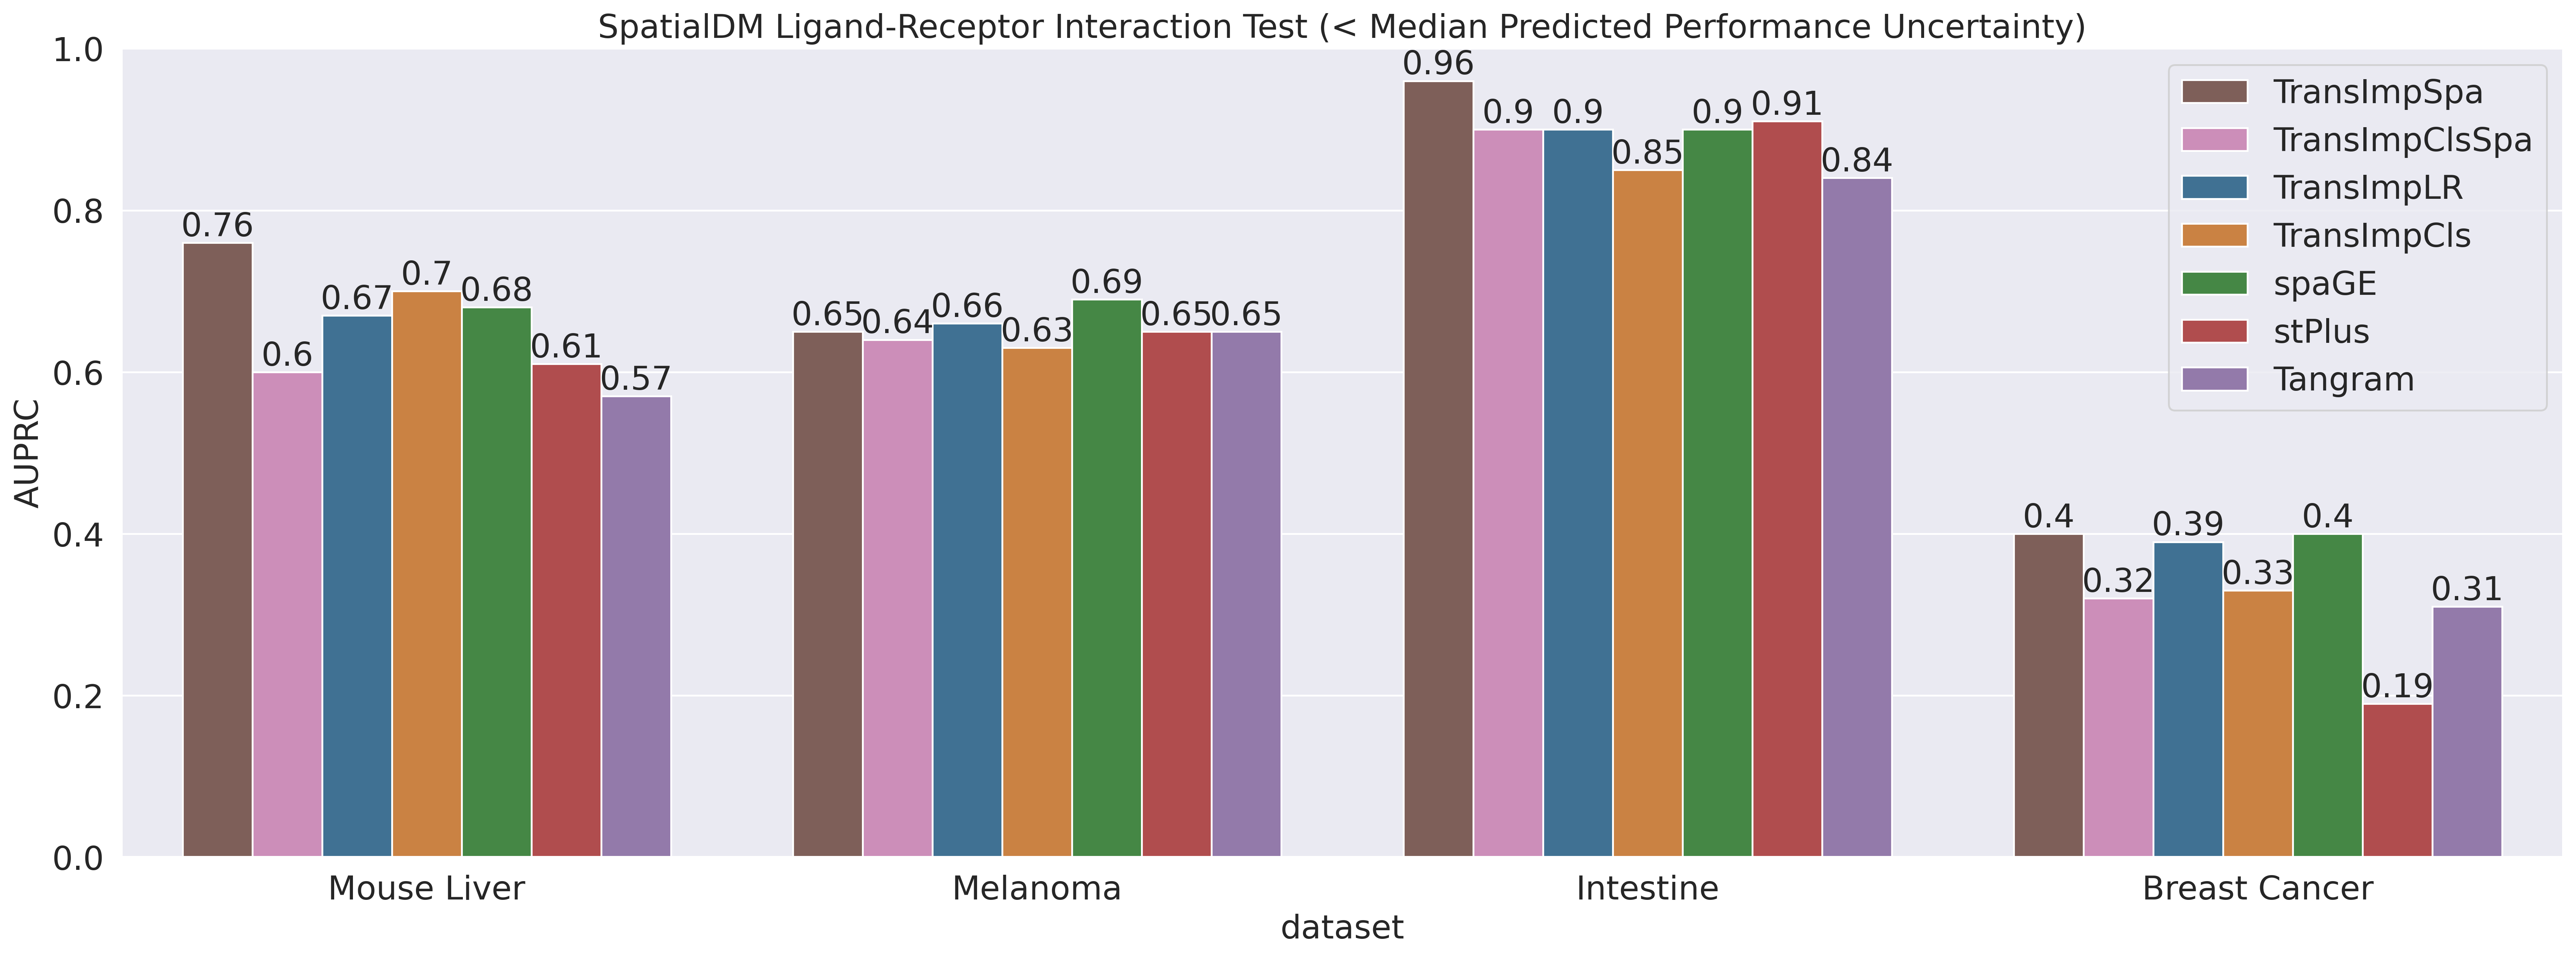

In [38]:
sns.set(rc={'figure.figsize':(24,8), 'figure.dpi':350, "font.size":18, 'axes.titlesize':18})
ax = sns.barplot(x="dataset", y="score", hue="method", hue_order=methods[:-1],
                 data=df_scores_sub.query('metric == "prec_rec"')
                                 .query('stats=="SDM"').query('method != "truth"').round(2), palette=color)
ax.set(
    ylabel='AUPRC', title='SpatialDM Ligand-Receptor Interaction Test (< Median Predicted Performance Uncertainty)', ylim=(0, 1.0))
for i in ax.containers:
    ax.bar_label(i,)
ax.set_ylabel(ylabel='AUPRC',fontsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.legend(loc="best", fontsize=18)
ax.set_yticklabels(ax.get_yticks().round(1), size = 18)
ax.set_xticklabels(datasets, size = 18)